# Modelo Gradient Boosting

* **BLOQUE 1**: Partición de los conjuntos de datos
* **BLOQUE 2**: Entrenamiento del modelo con todas las variables

### Librerías

In [ ]:
#install.packages('xgboost')
#install.packages('caret')
#install.packages('e1071')
#install.packages('pROC')
#install.packages('Ckmeans.1d.dp')
#install.packages('DiagrammeR')

library(xgboost)
library(caret)
library(e1071)
library(pROC)
library(Ckmeans.1d.dp)
library(ggplot2)
library(DiagrammeR)

## BLOQUE 1: Partición de los conjuntos de datos
En este primer bloque obtendremos los conjuntos necesarios para realizar el entrenamiento del modelo y poder observar y comparar el resultado del mismo.

In [ ]:
# Lectura del fichero .csv obtenido
data <- read.csv('dataPrepared.csv', sep = ',', header = TRUE)
head(data)

El objetivo de esta fase es la de dividir el dataset anterior en tres conjuntos distintos teniendo en cuenta que el número de observaciones entre clases es muy distinto:

* Conjunto de entrenamiento -> balanceado 
* Conjunto de validación  -> balanceado
* Conjunto de test -> no balanceado

_Balanceado_ : mismo número de observaciones de cada clase

El proceso a seguir es el siguiente:
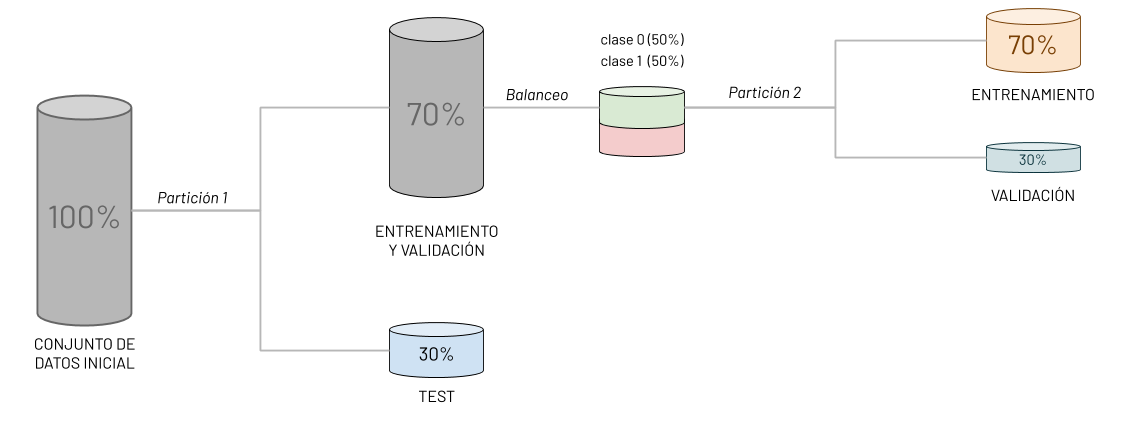

In [ ]:
# Realiza la partición 

# Pista: la librería caret tiene funciones maravillosas para partir conjuntos de datos preservando la distribución de las clases y para hacer downsampling ^^
df_test <- ?
df_train <- ?
df_valid <- ?

In [ ]:
# Tamaño final de los conjuntos.
cat('Tamaño del conjunto de entrenamiento:', nrow(df_train), '\n')
cat('Tamaño del conjunto de validación:', nrow(df_valid), '\n')
cat('Tamaño del conjunto de test:', nrow(df_test))

In [ ]:
# Separamos de los conjuntos la variable objeto de estudio
# Convertir en matrices, ya que la función para entrenar el modelo XGB no permite utilizar dataframes
X_train <- as.matrix(df_train[, which(names(df_train) != 'defecto')])
y_train <- df_train[, 'defecto']

X_valid <- as.matrix(df_valid[, which(names(df_valid) != 'defecto')])
y_valid <- df_valid[, 'defecto']

X_test <- as.matrix(df_test[, which(names(df_test) != 'defecto')])
y_test <- df_test[, 'defecto']

## BLOQUE 2: Entrenamiento del modelo con todas las variables

#### **¿Qué es _Boosting_?**

_Boosting_ es un meta-algoritmo de aprendizaje automático que reduce el sesgo y la varianza en un contexto de aprendizaje supervisado. Consiste en combinar los resultados de varios clasificadores débiles para obtener un clasificador robusto. Cuando se añaden estos clasificadores débiles, se hace de modo que éstos tengan diferente peso en función de la exactitud de sus predicciones. Tras añadir un clasificador débil, los datos cambian su estructura de pesos: los casos mal clasificados ganan peso y los que son clasificados correctamente pierden peso. 

**Gradient Boosting (GB)** o _Potenciación del gradiente_ consiste en plantear el problema como una optimización numérica en el que el objetivo es minimizar una función de coste añadiendo clasificadores débiles mediante el descenso del gradiente. Involucra tres elementos:

* La **función de coste** a optimizar: depende del tipo de problema a resolver.
* Un **clasificador débil** para hacer las predicciones: por lo general se usan árboles de decisión.
* Un **modelo que añade (ensambla) los clasificadores débiles** para minimizar la función de coste: se usa el descenso del gradiente para minimizar el coste al añadir árboles.

Para este problema utilizaremos la librería _XGBoost_, que es una implementación particular muy eficiente de Gradient Boosting.

Tutoriales de la librería en R:
* https://xgboost.readthedocs.io/en/latest/R-package/xgboostPresentation.html
* http://dmlc.github.io/rstats/2016/03/10/xgboost.html

Los hiperparámetros más importantes que intervienen en este algoritmo y que aquí utilizaremos se describen a continuación:

* Parámetros generales:
 * **nthread**: número de hilos paralelos usados en la ejecución.
 * **objetive**: objetivo del aprendizaje.
 * **eval_metric**: métrica de evaluación para el conjunto en cuestión.
 
 
* Parámetros propios del _Boosting_:
 * **eta (learning rate)**: determina el impacto de cada árbol en la salida final. Se parte de una estimación inicial que se va actualizando con la salida de cada árbol. Es el parámetro que controla la magnitud de las actualizaciones.
 * **nrounds**: número de árboles a utilizar.


* Parámetros propios de los árboles:
 * **max_depth**: profundidad máxima de un árbol.
 
Más información sobre los parámetros y la librería en general:
* https://xgboost.readthedocs.io/en/latest/parameter.html

In [ ]:
params <- list(objetive = 'binary:logistic',
               nthread = 4,
               max_depth = 6,
               eta = 0.3,
               eval_metric = 'auc')

xgb_model <- xgboost(data = ????, label = ????, params = ?????, nrounds = 30, verbose = 1, seed = 0)

In [ ]:
# Importancia de cada variable en el modelo
feature_importance <- xgb.importance(feature_names = ????, model = ????)
feature_importance

In [ ]:
# Gráfico con la importancia
options(repr.plot.width = 6, repr.plot.height = 3.5)
xgb.ggplot.importance(importance_matrix = feature_importance, rel_to_first = TRUE)

Para poder ver como de bueno es nuestro modelo, podemos obtener las predicciones que realiza sobre los conjuntos de entrenamiento y validación, y realizar el cálculo de alguna métrica para observar su rendimiento. En este caso, observaremos el **área bajo la curva ROC** (más conocido simplemente como AUC).

In [ ]:
# Ajuste/Rendimiento sobre datos de entrenamiento.
pred_train <- predict(xgb_model, X_train)

# Rendimiento sobre datos de validación
pred_valid <- predict(xgb_model, X_valid)

In [ ]:
# Creamos un dataframe con la probabilidad de ser o no defectuosa la pieza
# y añadimos el cálculo de la predicción final

# Entrenamiento
predictions_train <- data.frame('probability' = pred_train, 
                                'prediction' = ifelse(pred_train > 0.5, 1, 0))

# Validación
predictions_valid <- data.frame('probability' = pred_valid, 
                                'prediction' = ifelse(pred_valid > 0.5, 1, 0))

In [ ]:
# Cálculo de AUCs

# Entrenamiento
roc_train <- roc(y_train, predictions_train$prediction)
auc_train <- round(auc(roc_train), 4)

# Validación
roc_valid <- roc(y_valid, predictions_valid$prediction)
auc_valid <- round(auc(roc_valid), 4)

In [ ]:
cat(paste('Área bajo la curva (AUC) en entrenamiento:', auc_train, '\n'))
cat(paste('Área bajo la curva (AUC) en validación:', auc_valid))

Una vez entrenado el modelo, podemos observar su rendimiento sobre unos datos totalmente nuevos y más reales: el conjunto de test. Para ello, además de mostrar el AUC como veníamos haciendo a lo largo del análisis, observaremos también la **matriz de confusión**:

In [ ]:
# Predicciones en conjunto de test
pred_test <- predict(xgb_model, X_test)
pred_test <- ifelse(pred_test > 0.5, 1, 0)

# Área bajo la curva
roc_test <- roc(y_test, pred_test)
auc_test <- round(auc(roc_test), 4)

cat('Área bajo la curva (AUC) en test:', auc_test)

In [ ]:
# Matriz de confusión
cm_test <- round(prop.table(table(pred_test, y_test), 2)*100, 2)

cat('Matriz de confusión para datos de test:\n\n')
print(cm_test)

También es posible si se desea observar los árboles que son construidos en el modelo y que establecen las relaciones entre las variables utilizadas en cada uno de ellos:

In [ ]:
xgb.plot.tree(feature_names = xgb_model$feature_names, model = xgb_model, trees = 0)

Para terminar, debemos guardar nuestro modelo ya entrenado, de manera que cuando se desee utilizar solo sea necesario cargarlo y aplicarlo a nuevos conjuntos de datos.

In [ ]:
# Guardado del modelo ya entrenado
xgb.save(xgb_model, 'modelo_entrenado')

*Nota*: para conseguir un modelo eficiente y efectivo, sería conveniente hacer una selección de variables, pero por razones de tiempo se queda fuera de este seminario práctico.